# Epileptic Seizure Recognition

### Imports

In [1]:
import pandas
import numpy as np
from keras import *
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow import math
from plot_keras_history import plot_history

import pywt

## Dataset: University of Bonn EEG Dataset

This dataset contains EEG's from 500 subjects. The recordings were done for 23.5 seconds
and have resulted in 4097 datapoints. This data is divided into 23 chunks wich results
in 178 data points in one second. In total there are 11500 rows, each with 178 points.
Each of these rows has been labeled according to the state of the subject (column 'y'), where the labels have the following meaning:\
5 - Eyes open, means when they were recording the EEG signal of the brain the patient had their eyes open\
4 - Eyes closed, means when they were recording the EEG signal the patient had their eyes closed\
3 - The region of the tumor was identified and recording of the EEG activity was taken from the healthy brain area\
2 - The EEG recording was taken from the area where the tumor was located\
1 - Recording of seizure activity

 ### Metrics: Sensistivity and Specificity

In [3]:
def metrics(predicted, y_true):

    # compute true positives, true negatives, false positives, false negatives
    # for each class
    tp = np.zeros(5)
    tn = np.zeros(5)
    fp = np.zeros(5)
    fn = np.zeros(5)

    y_test_numpy = y_true.to_numpy()

    pred_conf = []
    true_conf = []
    
    specificity = []
    sensitivity = []
    
    for y_pred, y_true in zip(predicted, y_test_numpy):
    # here we transform the columns back to label form (from 1 to 5)
        a = np.where(y_pred == np.max(y_pred))[0][0]
        b = np.where(y_true == np.max(y_true))[0][0]

        pred_conf.append(a + 1)
        true_conf.append(b + 1)

        if a == b:
            tp[a] += 1
            for i in range(5):
                if i != a:
                    tn[i] += 1
        else:
            # we predicted a but it was b that means
            # for a we have a false positive and for b we have a false negative
            # for all the rest we have a true negative because we predicted something else
            # and it was something else
            fp[a] += 1
            fn[b] += 1
            for i in range(5):
                if i != a and i != b:
                    tn[i] += 1
    
    for i in range(5):
        sensitivity.append(tp[i] / (fn[i] + tp[i]))
        specificity.append(tn[i] / (tn[i] + fp[i]))

                    
    return sensitivity, specificity

## Importing and Visualizing the data

We can see that the data contains an unnamed column which represents the subject ID and the time of the
EEG recording in the following format X(time).V1.(ID), but since we're treating each second as individual
data it doesn't really matter for this study. The rest of the columns represent the datapoints in that second 'X1' - 'X178' and the last column 'y' is the label.\
We will be trying to predict the last column, so this is a multi label classification problem with 5 labels.

In [2]:
data_frame = pandas.read_csv("bonn_dataset.csv")
print(data_frame)

       Unnamed: 0   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  \
0      X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   
1      X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   
2         X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57   
3       X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   
4       X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4   
...           ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
11495  X22.V1.114  -22  -22  -23  -26  -36  -42  -45  -42  -45  ...    15   
11496  X19.V1.354  -47  -11   28   77  141  211  246  240  193  ...   -65   
11497    X8.V1.28   14    6  -13  -16   10   26   27   -9    4  ...   -65   
11498  X10.V1.932  -40  -25   -9  -12   -2   12    7   19   22  ...   121   
11499  X16.V1.210   29   41   57   72   74   62   54   43   31  ...   -59   

       X171  X172  X173  X174  X175  X176  X177  X178  y  
0       -15   -3

In [5]:
print(data_frame.columns)

Index(['Unnamed: 0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9',
       ...
       'X170', 'X171', 'X172', 'X173', 'X174', 'X175', 'X176', 'X177', 'X178',
       'y'],
      dtype='object', length=180)


#### Separate data points from the rest of the data frame.

In [3]:
first_column = data_frame.columns[0]

labels = data_frame['y']
data = data_frame.copy()
data.pop(first_column)
data.pop('y')
print(data)

        X1   X2   X3   X4   X5   X6   X7   X8   X9  X10  ...  X169  X170  \
0      135  190  229  223  192  125   55   -9  -33  -38  ...     8   -17   
1      386  382  356  331  320  315  307  272  244  232  ...   168   164   
2      -32  -39  -47  -37  -32  -36  -57  -73  -85  -94  ...    29    57   
3     -105 -101  -96  -92  -89  -95 -102 -100  -87  -79  ...   -80   -82   
4       -9  -65  -98 -102  -78  -48  -16    0  -21  -59  ...    10     4   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
11495  -22  -22  -23  -26  -36  -42  -45  -42  -45  -49  ...    20    15   
11496  -47  -11   28   77  141  211  246  240  193  136  ...   -94   -65   
11497   14    6  -13  -16   10   26   27   -9    4   14  ...   -42   -65   
11498  -40  -25   -9  -12   -2   12    7   19   22   29  ...   114   121   
11499   29   41   57   72   74   62   54   43   31   23  ...   -94   -59   

       X171  X172  X173  X174  X175  X176  X177  X178  
0       -15   -31   -77  -103  

#### Visualization of a signal

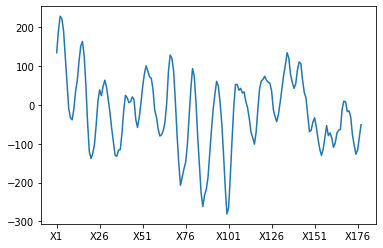

In [7]:
row = data.iloc[0]
row.plot()
pyplot.show()
# print(labels[0])

### Filter data using discrete wavelet transform

In [11]:
# row.plot()
# pyplot.show()
def filter_data(data):
        
    # This function applies discrete wavelet transform on the data to extract
    # approxiamte and detailed coefficients for 1 level using wavelets db6, sym6 and coif2     
    
    filtered_data = []
    wavelets = ['db6', 'sym6', 'coif2'] # all these wavelets produce coefficients of the same length

    for i in range(len(data)):
        row = data.iloc[i]

        new_row = []

        for wt in wavelets:
            ca, cd = pywt.dwt(row, wt)
            new_row.append(ca)
            new_row.append(cd)

        filtered_data.append(np.array(new_row))

    filtered_data = np.array(filtered_data)
    

    return filtered_data

#### Example of DWT

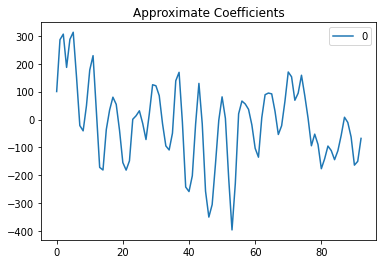

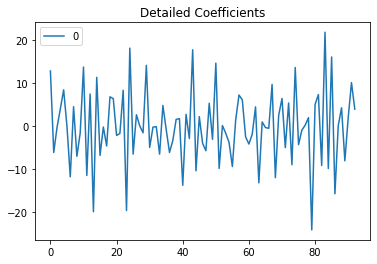

In [8]:
row = data.iloc[0]

ca, cd = pywt.dwt(row, 'db5')
ca = pandas.DataFrame(ca)
cd = pandas.DataFrame(cd)

ca.plot(title="Approximate Coefficients")
cd.plot(title="Detailed Coefficients")

pyplot.show()

### 10-fold cross validation

In [32]:
def cross_validation(model_fct, shape, data, labels):

    # Test the model using 10 fold cross validation
    # random_state is use, so the same result will be obtained
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1337)

    accuracy_fold = []
    loss_fold = []
    sensitivity_fold = []
    specificity_fold = []


    fold_nr = 0

    for train_indexes, test_indexes in kf.split(data, labels):
        x_train = data[train_indexes]
        y_train_multilabel = labels.iloc[train_indexes]
        y_train = pandas.get_dummies(y_train_multilabel, prefix='state')


        x_test = data[test_indexes]
        y_test_multilabel = labels.iloc[test_indexes]
        y_test = pandas.get_dummies(y_test_multilabel, prefix='state')

        # define a new model
        model = model_fct(shape)
        model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

        print("----------------------------------------------------------------------")
        print("Training for fold nr: {}".format(fold_nr))
        history = model.fit(x_train, y_train, batch_size=32, epochs=50, verbose=0)

        loss, accuracy = model.evaluate(x_test, y_test)

        print("Test Loss: {}".format(loss))
        print("Test Accuracy: {}".format(accuracy))

        predicted = model.predict(x_test)

        sensitivity, specificity = metrics(predicted, y_test)

        for i in range(5):
            print("Sensitivity for class {}: {}".format(i + 1, sensitivity[i]))
            print("Specificity for class {}: {}".format(i + 1, specificity[i]))

        accuracy_fold.append(accuracy)
        loss_fold.append(loss)

        sensitivity_fold.append(sensitivity)
        specificity_fold.append(specificity)

        fold_nr += 1
        print("----------------------------------------------------------------------")
        
    return loss_fold, accuracy_fold, sensitivity_fold, specificity_fold

## Method 1
This method is quite naive, we split the data into training data and test data, and feed into a neural network with fully connected layers. The optimizer that was used is adam with default parameters, and the model was trained for 50 epochs using 10-fold cross validation. A dropout layer is introduced to reduce overfitting of the data. More details are shown below in the model summary

In [5]:
def fully_connected(shape):

    model = Sequential(name="fully_connected")
    model.add(Input(shape=shape[0]))
    model.add(layers.Flatten())
    model.add(layers.Dense(300, activation='sigmoid'))
    model.add(layers.Dense(100, activation='sigmoid'))
    model.add(layers.Dense(20, activation='sigmoid'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))

    return model

fcnn = fully_connected(data.shape).summary()
utils.plot_model(fcnn, to_file="fcnn.png", show_shapes=True)

Model: "fully_connected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 11500)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 300)               3450300   
_________________________________________________________________
dense_5 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_6 (Dense)              (None, 20)                2020      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 105       
Total params: 3,482,525
Trainable params: 3,482,525
Non-trainable params: 0
_________________________________________

In [38]:
loss, acc, sensitivity, specificity = cross_validation(fully_connected, (data.shape[1], 1), data.to_numpy(), labels)

print("Average Loss for the model: {}".format(sum(loss) / 10))
print("Average accuracy for the model: {}".format(sum(acc) / 10))

for i in range(5):
    avg_sensitivity = sum([x[i] for x in sensitivity]) / 10
    avg_specificity = sum([x[i] for x in specificity]) / 10
    print("Average sensitivity for the model for class {}: {}".format(i + 1, avg_sensitivity))
    print("Average specificity for the model for class {}: {}".format(i + 1, avg_specificity))

----------------------------------------------------------------------
Training for fold nr: 0
36/36 [==============================] - 0s 2ms/step - loss: 1.1812 - accuracy: 0.5330
Test Loss: 1.181178331375122
Test Accuracy: 0.5330435037612915
Sensitivity for class 1: 0.7478260869565218
Specificity for class 1: 0.9130434782608695
Sensitivity for class 2: 0.43478260869565216
Specificity for class 2: 0.8358695652173913
Sensitivity for class 3: 0.46956521739130436
Specificity for class 3: 0.8673913043478261
Sensitivity for class 4: 0.5695652173913044
Specificity for class 4: 0.9369565217391305
Sensitivity for class 5: 0.4434782608695652
Specificity for class 5: 0.8630434782608696
----------------------------------------------------------------------
----------------------------------------------------------------------
Training for fold nr: 1
36/36 [==============================] - 0s 1ms/step - loss: 1.2137 - accuracy: 0.5096
Test Loss: 1.2137118577957153
Test Accuracy: 0.5095652341842

Average accuracy for the model is about 50%, specificity is usually pretty good since we try to predict 5 classes, sensitivity for class 1 (seizure) is 70%, which is an expected result as the difference between this class and the others is much easier to asses. 

Next we use the detailed coefficients from the db6 wavelet to train the model.

In [39]:
filtered_data = filter_data(data)
# we use just the detailed coefficients from db6
filtered_data = np.array([x[1] for x in filtered_data])

loss, acc, sensitivity, specificity = cross_validation(fully_connected, (filtered_data.shape[1], 1), filtered_data, labels)

print("Average Loss for the model: {}".format(sum(loss) / 10))
print("Average accuracy for the model: {}".format(sum(acc) / 10))

for i in range(5):
    avg_sensitivity = sum([x[i] for x in sensitivity]) / 10
    avg_specificity = sum([x[i] for x in specificity]) / 10
    print("Average sensitivity for the model for class {}: {}".format(i + 1, avg_sensitivity))
    print("Average specificity for the model for class {}: {}".format(i + 1, avg_specificity))

----------------------------------------------------------------------
Training for fold nr: 0
36/36 [==============================] - 0s 944us/step - loss: 2.9357 - accuracy: 0.4861
Test Loss: 2.9357352256774902
Test Accuracy: 0.48608696460723877
Sensitivity for class 1: 0.7347826086956522
Specificity for class 1: 0.9228260869565217
Sensitivity for class 2: 0.43478260869565216
Specificity for class 2: 0.8880434782608696
Sensitivity for class 3: 0.21304347826086956
Specificity for class 3: 0.8978260869565218
Sensitivity for class 4: 0.6391304347826087
Specificity for class 4: 0.8565217391304348
Sensitivity for class 5: 0.40869565217391307
Specificity for class 5: 0.7923913043478261
----------------------------------------------------------------------
----------------------------------------------------------------------
Training for fold nr: 1
36/36 [==============================] - 0s 917us/step - loss: 2.5563 - accuracy: 0.5052
Test Loss: 2.556278705596924
Test Accuracy: 0.5052173

When filtering out the signal the model seems to perform slightly worse, having an acuracy of only 48%. Sensitivity for most classes is about 50% except for class 1 (seizure) where it is almost 70% and for class 3 (EEG from healthy part brain, when patient has brain tumor).\
All in all this model does not perform all that well on this type of classification problem, but for binary classification (seizure vs. non-seizure) it might have a pretty good accuracy.

## Method 2
This method uses convolutional nerual networks to classify the signal. The model has 3 1D convolutional layers each with a different number of filters with different size kernels. Before the classification layers the size of the output is reduced using a 1D max pooling layer. For classification 2 dense layers are used. The convolution layers use ReLU as the activation function, whereas the first dense layer uses sigmoid activation and the last layer uses softmax to classify the data. The optimizer and the loss function are the same as in the above method: Adam optimizers with default parameters and categorical cross entropy to compute the loss.

In [42]:
def cnn(shape):
    model = Sequential(name='cnn')

    inputs = Input(shape=(shape[0], shape[1]))

    model.add(inputs)
    model.add(layers.Reshape((shape[0], shape[1])))
    # model.add(layers.Conv1D(64, 25, activation='relu'))
    model.add(layers.Conv1D(32, 15, activation='relu'))
    model.add(layers.Conv1D(16, 10, activation='relu'))
    model.add(layers.Conv1D(8, 5, activation='relu'))
    model.add(layers.MaxPooling1D())
    model.add(layers.Flatten())
    # model.add(layers.Dense(100, activation='sigmoid'))
    model.add(layers.Dense(40, activation='sigmoid'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='softmax'))
    
    return model

cnn((data.shape[1], 1)).summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_18 (Reshape)         (None, 178, 1)            0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 164, 32)           512       
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 155, 16)           5136      
_________________________________________________________________
conv1d_56 (Conv1D)           (None, 151, 8)            648       
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 75, 8)             0         
_________________________________________________________________
flatten_64 (Flatten)         (None, 600)               0         
_________________________________________________________________
dense_220 (Dense)            (None, 40)                24040   

In [43]:
loss, acc, sensitivity, specificity = cross_validation(cnn, (data.shape[1], 1), data.to_numpy(), labels)

print("Average Loss for the model: {}".format(sum(loss) / 10))
print("Average accuracy for the model: {}".format(sum(acc) / 10))

for i in range(5):
    avg_sensitivity = sum([x[i] for x in sensitivity]) / 10
    avg_specificity = sum([x[i] for x in specificity]) / 10
    print("Average sensitivity for the model for class {}: {}".format(i + 1, avg_sensitivity))
    print("Average specificity for the model for class {}: {}".format(i + 1, avg_specificity))

----------------------------------------------------------------------
Training for fold nr: 0
36/36 [==============================] - 0s 3ms/step - loss: 0.5144 - accuracy: 0.7704
Test Loss: 0.5143756866455078
Test Accuracy: 0.7704347968101501
Sensitivity for class 1: 0.9695652173913043
Specificity for class 1: 0.9891304347826086
Sensitivity for class 2: 0.43478260869565216
Specificity for class 2: 0.9402173913043478
Sensitivity for class 3: 0.7434782608695653
Specificity for class 3: 0.8673913043478261
Sensitivity for class 4: 0.9260869565217391
Specificity for class 4: 0.9489130434782609
Sensitivity for class 5: 0.7782608695652173
Specificity for class 5: 0.967391304347826
----------------------------------------------------------------------
----------------------------------------------------------------------
Training for fold nr: 1
36/36 [==============================] - 0s 3ms/step - loss: 0.4841 - accuracy: 0.7643
Test Loss: 0.4841070771217346
Test Accuracy: 0.76434785127639

This model is a bit of an improvement over the previous one, yielding an accuracy of 74%.

In [55]:
filtered_data = filter_data(data)

shape = filtered_data.shape
reshaped = filtered_data.reshape((shape[0], shape[2], shape[1]))

# print(reshaped)

loss, acc, sensitivity, specificity = cross_validation(cnn, reshaped.shape[1:], reshaped, labels)

print("Average Loss for the model: {}".format(sum(loss) / 10))
print("Average accuracy for the model: {}".format(sum(acc) / 10))

for i in range(5):
    avg_sensitivity = sum([x[i] for x in sensitivity]) / 10
    avg_specificity = sum([x[i] for x in specificity]) / 10
    print("Average sensitivity for the model for class {}: {}".format(i + 1, avg_sensitivity))
    print("Average specificity for the model for class {}: {}".format(i + 1, avg_specificity))

----------------------------------------------------------------------
Training for fold nr: 0
36/36 [==============================] - 0s 3ms/step - loss: 1.2216 - accuracy: 0.4061
Test Loss: 1.2216006517410278
Test Accuracy: 0.4060869514942169
Sensitivity for class 1: 0.0
Specificity for class 1: 1.0
Sensitivity for class 2: 0.5478260869565217
Specificity for class 2: 0.8130434782608695
Sensitivity for class 3: 0.29130434782608694
Specificity for class 3: 0.9543478260869566
Sensitivity for class 4: 0.9565217391304348
Specificity for class 4: 0.6282608695652174
Sensitivity for class 5: 0.23478260869565218
Specificity for class 5: 0.8619565217391304
----------------------------------------------------------------------
----------------------------------------------------------------------
Training for fold nr: 1
36/36 [==============================] - 0s 2ms/step - loss: 1.0083 - accuracy: 0.5513
Test Loss: 1.0082751512527466
Test Accuracy: 0.5513043403625488
Sensitivity for class 1: 

When decomposing the signal we get a lower accuracy of 48% than when passing the signal raw.

## Method 3
In the third method RNN was used to classify the input signal. This model consists of one GRU layer with 64 cells and 2 dense layers for classification as in the previous models. As it takes a lot of time to train this network, this will be tested without 10-fold cross validation

In [57]:
def rnn(shape):
    model = Sequential(name='rnn')

    inputs = Input(shape=shape)
    
    model.add(inputs)
    model.add(layers.Reshape(shape))    
    
    model.add(layers.GRU(64))
    
    model.add(layers.Dense(20, activation='sigmoid'))
    model.add(layers.Dense(5, activation='softmax'))
    
    return model

rnn((data.shape[1], 1)).summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_48 (Reshape)         (None, 178, 1)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                12864     
_________________________________________________________________
dense_264 (Dense)            (None, 20)                1300      
_________________________________________________________________
dense_265 (Dense)            (None, 5)                 105       
Total params: 14,269
Trainable params: 14,269
Non-trainable params: 0
_________________________________________________________________


In [58]:
x_train, x_test, y_train, y_test = train_test_split(data, pandas.get_dummies(labels, prefix='state'), random_state=1337)

model = rnn((data.shape[1], 1))
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=32, epochs=50)

Epoch 1/50
270/270 [==============================] - 19s 70ms/step - loss: 1.2778 - accuracy: 0.4373
Epoch 2/50
270/270 [==============================] - 17s 65ms/step - loss: 0.9717 - accuracy: 0.5870
Epoch 3/50
270/270 [==============================] - 20s 76ms/step - loss: 0.8579 - accuracy: 0.6243
Epoch 4/50
270/270 [==============================] - 22s 80ms/step - loss: 0.7653 - accuracy: 0.6580
Epoch 5/50
270/270 [==============================] - 21s 79ms/step - loss: 0.7213 - accuracy: 0.6692
Epoch 6/50
270/270 [==============================] - 22s 82ms/step - loss: 0.6956 - accuracy: 0.6821
Epoch 7/50
270/270 [==============================] - 22s 83ms/step - loss: 0.6907 - accuracy: 0.6830
Epoch 8/50
270/270 [==============================] - 22s 83ms/step - loss: 0.6777 - accuracy: 0.6908
Epoch 9/50
270/270 [==============================] - 22s 82ms/step - loss: 0.6499 - accuracy: 0.6990
Epoch 10/50
270/270 [==============================] - 23s 84ms/step - loss: 0.652

90/90 [==============================] - 1s 15ms/step - loss: 0.6163 - accuracy: 0.7158 0s - loss:
Loss for the model: 0.6162939667701721
Accuracy for the model: 0.7158260941505432
Sensitivity for the model for class 1: 0.9604810996563574
Specificity for the model for class 1: 0.9908416921064108
Sensitivity for the model for class 2: 0.458477508650519
Specificity for the model for class 2: 0.91162385720505
Sensitivity for the model for class 3: 0.5904255319148937
Specificity for the model for class 3: 0.8797057550843791
Sensitivity for the model for class 4: 0.7853492333901193
Specificity for the model for class 4: 0.9453671328671329
Sensitivity for the model for class 5: 0.7801418439716312
Specificity for the model for class 5: 0.9177845088706188


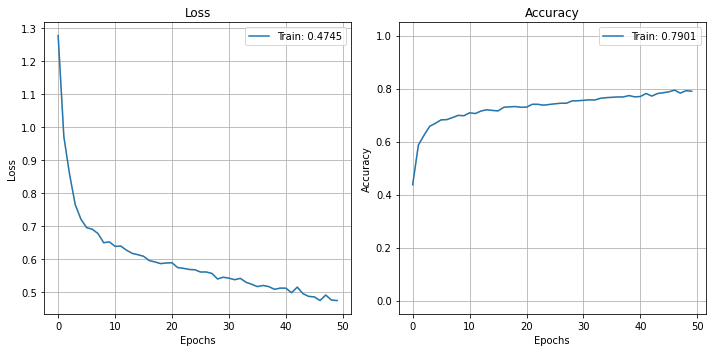

In [61]:
plot_history(history.history)

loss, accuracy = model.evaluate(x_test, y_test)

predicted = model.predict(x_test)
sensitivity, specificity = metrics(predicted, y_test)

print("Loss for the model: {}".format(loss))
print("Accuracy for the model: {}".format(accuracy))

for i in range(5):
    print("Sensitivity for the model for class {}: {}".format(i + 1, sensitivity[i]))
    print("Specificity for the model for class {}: {}".format(i + 1, specificity[i]))

This RNN model looks to have a accuracy of about 71%, which is a little lower than the CNN model, but still promising.

In [72]:
filtered = filter_data(data)
shape = filtered.shape
reshaped = filtered.reshape((shape[0], shape[2], shape[1]))

x_train, x_test, y_train, y_test = train_test_split(reshaped, pandas.get_dummies(labels, prefix='state'), random_state=1337)

# print(reshaped.shape)


model = rnn(reshaped.shape[1:])
model.summary()
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=32, epochs=50)

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_56 (Reshape)         (None, 94, 6)             0         
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                13824     
_________________________________________________________________
dense_280 (Dense)            (None, 20)                1300      
_________________________________________________________________
dense_281 (Dense)            (None, 5)                 105       
Total params: 15,229
Trainable params: 15,229
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
270/270 [==============================] - 9s 33ms/step - loss: 1.3595 - accuracy: 0.3968
Epoch 2/50
270/270 [==============================] - 9s 32ms/step - loss: 1.0031 - accuracy: 0.5754
Epoch 3/50
270/270 [==============================] - 9

90/90 [==============================] - 1s 8ms/step - loss: 1.1434 - accuracy: 0.6637
Loss for the model: 1.1433573961257935
Accuracy for the model: 0.6636521816253662
Sensitivity for the model for class 1: 0.8797250859106529
Specificity for the model for class 1: 0.9720889664195377
Sensitivity for the model for class 2: 0.5155709342560554
Specificity for the model for class 2: 0.8659120592076621
Sensitivity for the model for class 3: 0.5088652482269503
Specificity for the model for class 3: 0.8853310255300736
Sensitivity for the model for class 4: 0.7836456558773425
Specificity for the model for class 4: 0.9357517482517482
Sensitivity for the model for class 5: 0.6223404255319149
Specificity for the model for class 5: 0.9208135006490696


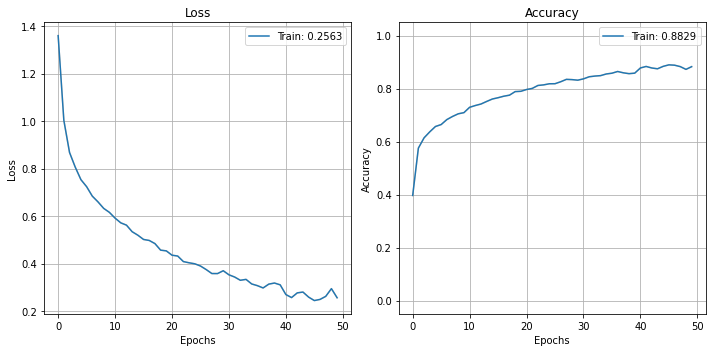

In [73]:
plot_history(history.history)

loss, accuracy = model.evaluate(x_test, y_test)

predicted = model.predict(x_test)
sensitivity, specificity = metrics(predicted, y_test)

print("Loss for the model: {}".format(loss))
print("Accuracy for the model: {}".format(accuracy))

for i in range(5):
    print("Sensitivity for the model for class {}: {}".format(i + 1, sensitivity[i]))
    print("Specificity for the model for class {}: {}".format(i + 1, specificity[i]))